# Absolute Camera Pose Estimation (Perspective-n-Point; PnP)

- Unknown : Camera pose (6 DoF)
- Given : 3D points $X_1, X_2, \dots, X_n,$ their projected points $x_1, x_2, \dots, x_n,$ and camera matrix $K$
- Constraints : n x projection $x_i = K[R|t]X_i$
- Solution (n $\ge$ 3) → 3-point algorithm
    - OpenCV `cv::solvePnP()` and `cv::solvePnPRansac()`
    - Efficient PnP (EPnP), http://cvlab.epfl.ch/EPnP/

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Video Path
input = "../bin/data/chessboard.avi"

# Given Camera Intrinsic Parameter
K = np.array([[432.7390364738057, 0, 476.0614994349778],
              [0, 431.2395555913084, 288.7602152621297],
              [0, 0, 1]], dtype=np.float32)
dist_coeff = np.array([-0.2852754904152874, 0.1016466459919075, -0.0004420196146339175, 
                       0.0001149909868437517, -0.01803978785585194], dtype=np.float32)

# Chessboard Pattern
board_pattern = (10, 7)
board_cellsize = 0.025

# Calibration Criteria
criteria = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK

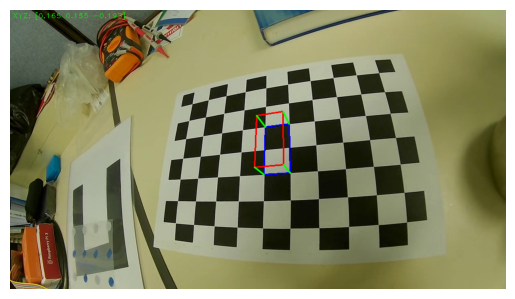

In [3]:
# Prepare given chessboard coordinate 3D Points
obj_points = np.zeros((board_pattern[0]*board_pattern[1],3), dtype=np.float32)
obj_points[:, :2] = np.mgrid[0:board_pattern[0], 0:board_pattern[1]].T.reshape(-1, 2) * board_cellsize

# Prepare a 3D box for simple AR
box_lower = np.array([[4 ,2, 0], [5, 2, 0], [5, 4, 0], [4, 4, 0]], dtype=np.float32) * board_cellsize
box_upper = np.array([[4, 2, -1], [5, 2, -1], [5, 4, -1], [4, 4, -1]], dtype=np.float32) * board_cellsize

# Open a Video
cap = cv2.VideoCapture(input)

# Run Pose Estimation
while True:
    ret, image = cap.read()
    if not ret: break
    
    # Find Chessboard corner 2D Points
    ret, img_points = cv2.findChessboardCorners(image, board_pattern, criteria)
    if ret: # if we can find
        # SolvePnP (Given 3D Points, 2D Points and Camera Matrix K)
        ret, rvec, tvec = cv2.solvePnP(obj_points, img_points, K, dist_coeff)
        
        # Draw the box on the image
        line_lower, _ = cv2.projectPoints(box_lower, rvec, tvec, K, dist_coeff)
        line_upper, _ = cv2.projectPoints(box_upper, rvec, tvec, K, dist_coeff)
        
        # Change 4x1 Matrix (CV_64FC2) to 4x2 (CV_32SC1) / np.int32([line_lower]) or line_lower.reshape(-1, 1, 2)
        image = cv2.polylines(image, np.int32([line_lower]), True, (255, 0, 0), 2)
        image = cv2.polylines(image, np.int32([line_upper]), True, (0, 0, 255), 2)
        for lower, upper in zip(line_lower, line_upper):
            image = cv2.line(image, np.int32(lower[0]), np.int32(upper[0]), (0, 255, 0), 2, cv2.LINE_AA)
            
        # Print Camera Position
        R, _ = cv2.Rodrigues(rvec)
        t = -R.T @ tvec
        string_info = f"XYZ: [{t.T[0][0]:.3f} {t.T[0][1]:.3f} {t.T[0][2]:.3f}]"
        image = cv2.putText(image, string_info, (5,16), cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 0))
    
    cv2.imshow("3DV Tutorial: Pose Estimation (Chess board)", image)
    if cv2.waitKey(1) == 27: break # 'ESC' Key Exit

cap.release()
cv2.destroyAllWindows()

plt.imshow(image[:, :, (2, 1, 0)])
plt.axis('off')
plt.show()